In [24]:
import numpy as np
import os 
import matplotlib.pyplot as plt

In [67]:
def load_partial(folder, height, batchsize, overlap):
    lowerh = 0
    upperh = batchsize
    partial = []
    while(height-upperh >= batchsize):
        p = np.load(os.path.join(folder, str(lowerh)+'to'+str(upperh)) + '.npy')
        partial.append(p)
        lowerh = upperh - overlap
        upperh = lowerh + batchsize
    p = np.load(os.path.join(folder, str(lowerh)+'to'+str(height)) + '.npy')
    partial.append(p)
    return partial

def stitch(partial, height, batchsize, overlap):
    lowerh = 0
    upperh = batchsize
    full = np.full((height, partial[0].shape[1]), -1)
    hoverlap = overlap/2
    i = 0
    while(height-upperh >= batchsize):
        # print(lowerh, upperh)
        if(lowerh==0):
            full[int(lowerh):int(upperh-hoverlap)] = partial[i][0:int(batchsize-hoverlap)]
        else:
            full[int(lowerh+hoverlap):int(upperh-hoverlap)] = partial[i][int(hoverlap):int(batchsize-hoverlap)]
        lowerh = upperh - overlap
        upperh = lowerh + batchsize
        i+=1
    full[int(lowerh+hoverlap):] = partial[i][int(hoverlap):]
    return full

In [41]:
def interpolate(disparity, maxdisp):
    average = np.average(disparity[:,0:-maxdisp])
    for i in range(disparity.shape[0]):
        interpolate=False
        start = -1
        startval = -1
        end = -1
        endval = -1
        for j in range(disparity.shape[1]-maxdisp):
            if(interpolate==False and disparity[i,j] == -1):
                interpolate = True
                start = j
                if(j-1 <0):
                    startval=average
                else:
                    startval = disparity[i,j-1]
            if(interpolate==True and disparity[i,j] != -1):
                interpolate = False
                end = j
                endval = disparity[i,j]
                values = np.arange(1,end-start+1)
                values = values**2 * (endval-startval)/((end-start+1)**2) + startval
                disparity[i,start:end] = values
                interpolate = False
        if(interpolate==True):
            endval = average
            end = disparity.shape[1]-maxdisp-1
            values = np.arange(1,end-start+1)
            values = values * (endval-startval)/(end-start+1) + startval
            disparity[i,start:end] = values
            interpolate = False
    


In [48]:
partial = load_partial("run\\tsukuba", 288, 50, 10)
full = stitch(partial, 288, 50, 10)

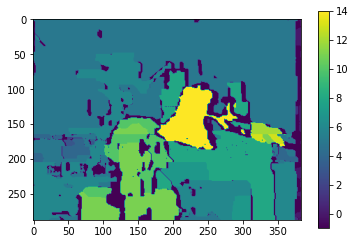

In [30]:
plt.imshow(full)
plt.colorbar()

In [31]:
partial2 = load_partial("run\\recycle2", 275, 50, 8)

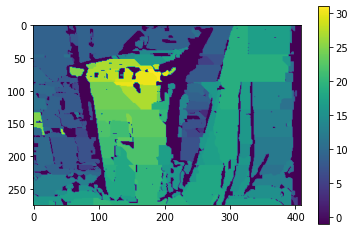

In [42]:
full2 = stitch(partial2, 275, 50,8)
plt.imshow(full2)
plt.colorbar()

In [46]:
interpolate(full, 32)

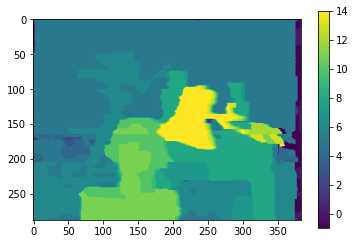

In [47]:

plt.imshow(full)
plt.colorbar()

In [45]:
np.save("full.npy", full2)

In [53]:
partial3 = load_partial("run\\mask", 287, 40, 8)
full3 = stitch(partial3, 287, 40, 8)

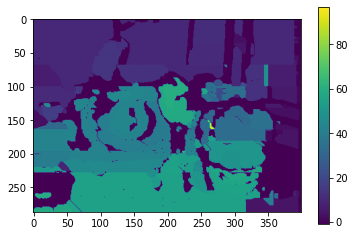

In [54]:
plt.imshow(full3)
plt.colorbar()

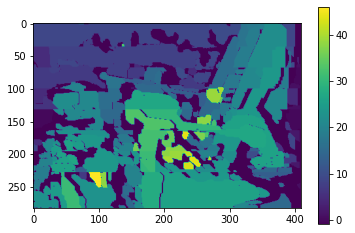

In [56]:
partial4 = load_partial("run\\Adirondack", 283, 40, 8)
full4 = stitch(partial4, 283, 40, 8)
plt.imshow(full4)
plt.colorbar()

(60, 423)


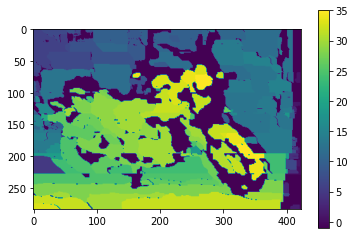

In [61]:
partial5 = load_partial("run\\Motorcycle", 284, 40, 8)
print(partial5[-1].shape)
full5 = stitch(partial5, 284, 40, 8)
plt.imshow(full5)
plt.colorbar()

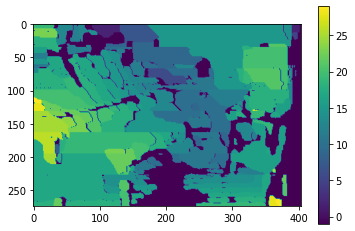

In [63]:
partial6 = load_partial("run\\Piano", 275, 40, 8)
full6 = stitch(partial6, 275, 40, 8)
plt.imshow(full6)
plt.colorbar()

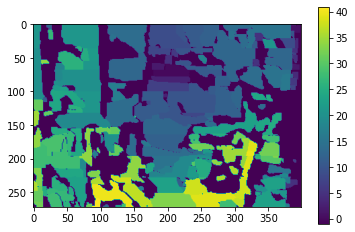

In [68]:
partial7 = load_partial("run\\Playroom", 272, 40, 8)
full7 = stitch(partial7, 272, 40, 8)
plt.imshow(full7)
plt.colorbar()

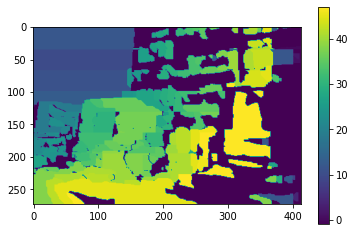

In [69]:
partial8 = load_partial("run\\Vintage", 274, 40, 8)
full8 = stitch(partial8, 274, 40, 8)
plt.imshow(full8)
plt.colorbar()

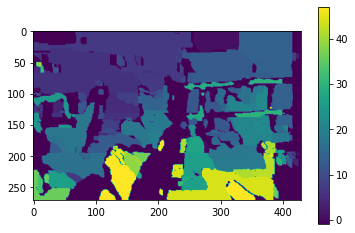

In [70]:
partial9 = load_partial("run\\Classroom2", 271, 40, 8)
full9 = stitch(partial9, 271, 40, 8)
plt.imshow(full9)
plt.colorbar()

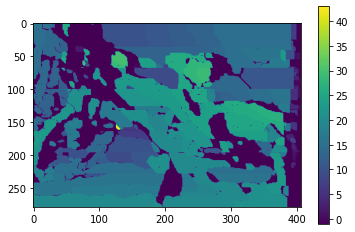

In [72]:
partial10 = load_partial("run\\Bicycle2", 279, 40, 8)
full10 = stitch(partial10, 279, 40, 8)
plt.imshow(full10)
plt.colorbar()